### For this project, we have used Microsoft S&P stock profile for time series analysis using ARIMA and SARIMA models.

In [26]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
 pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
register_matplotlib_converters()
from time import time
from sklearn.metrics import mean_squared_error
from math import sqrt

In [29]:
tickrsym = 'MSFT'

In [30]:
tickrdata = yf.Ticker(tickrsym)

In [31]:
tickr = tickrdata.history(interval='1d', start='2019-1-1', end='2020-4-10')

In [32]:
tickr

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-01-02 00:00:00-05:00,94.724277,96.817628,94.143846,96.218170,35329300,0.0,0.0
2019-01-03 00:00:00-05:00,95.247595,95.333236,92.488173,92.678482,42579100,0.0,0.0
2019-01-04 00:00:00-05:00,94.886016,97.540770,94.134311,96.988884,44060600,0.0,0.0
2019-01-07 00:00:00-05:00,96.712948,98.263931,96.084946,97.112587,35656100,0.0,0.0
2019-01-08 00:00:00-05:00,98.045075,98.929993,96.779546,97.816711,31514400,0.0,0.0
...,...,...,...,...,...,...,...
2020-04-03 00:00:00-04:00,150.172635,152.380201,147.355080,148.942978,41243300,0.0,0.0
2020-04-06 00:00:00-04:00,155.226821,161.210482,152.573862,160.019562,67111700,0.0,0.0
2020-04-07 00:00:00-04:00,164.202345,164.599323,158.073439,158.296143,62769000,0.0,0.0


### Since, we are interested only in closing price of the Microsoft stock and the date associated with it hence, we are dropping other columns for our further analysis.

In [33]:
tickrdf = tickr.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'], axis = 1)

In [34]:
tickrdf.head()

,Close
Date,
2019-01-02 00:00:00-05:00,96.218170
2019-01-03 00:00:00-05:00,92.678482
2019-01-04 00:00:00-05:00,96.988884
2019-01-07 00:00:00-05:00,97.112587
2019-01-08 00:00:00-05:00,97.816711


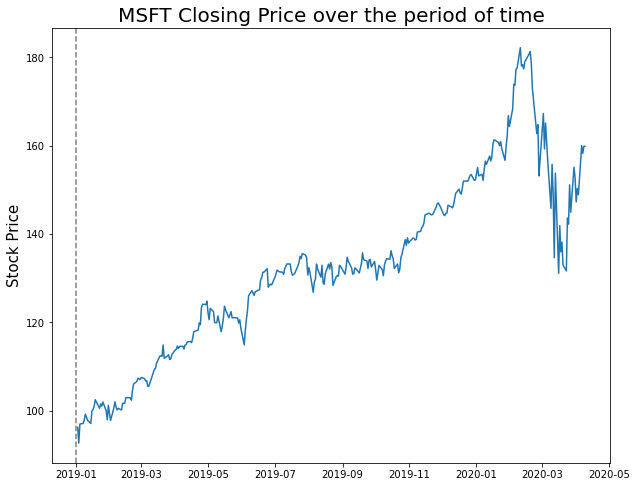

In [35]:
plt.figure(figsize = (10,8))
plt.plot(tickrdf.Close)
plt.title('MSFT Closing Price over the period of time', fontsize = 20)
plt.ylabel('Stock Price', fontsize = 15)
for year in range(2019, 2020):
    plt.axvline(pd.to_datetime(str(year)), color = 'k', linestyle = '--', alpha = 0.5)

## Stationarity Testing

In [36]:
test_result=adfuller(tickrdf['Close'])

In [37]:
def adfuller_test(close):
    result=adfuller(close)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [38]:
adfuller_test(tickrdf['Close'])

ADF Test Statistic : -1.4391896939087137
p-value : 0.5633506622655591
#Lags Used : 9
Number of Observations Used : 311
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


#### Since, the data is non-stationary, so we need to transform the data using the first differencing technique.

## First Differencing Technique

In [39]:
first_diffs = tickrdf.Close.values[1:] - tickrdf.Close.values[:-1] 
first_diffs = np.concatenate([first_diffs, [0]])

In [40]:
tickrdf['First_Difference'] = first_diffs

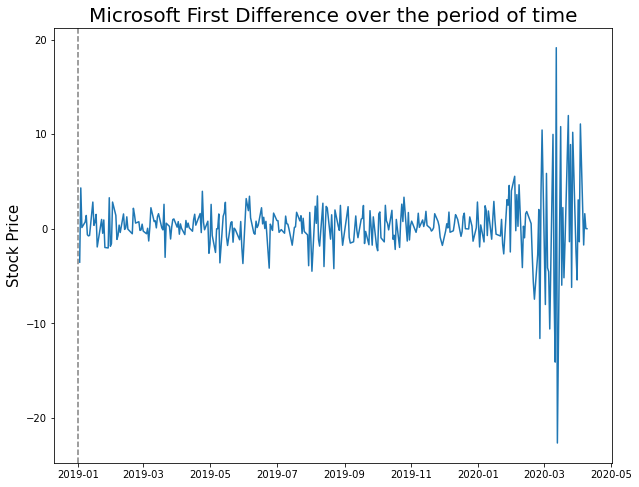

In [41]:
plt.figure(figsize = (10,8))
plt.plot(tickrdf.First_Difference)
plt.title('Microsoft First Difference over the period of time', fontsize = 20)
plt.ylabel('Stock Price', fontsize = 15)
for year in range(2019, 2020):
    plt.axvline(pd.to_datetime(str(year)), color = 'k', linestyle = '--', alpha = 0.5)

## Again, testing Stationarity

In [42]:
adfuller_test(tickrdf['First_Difference'].dropna())

ADF Test Statistic : -4.874533106758442
p-value : 3.908137456703153e-05
#Lags Used : 8
Number of Observations Used : 312
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


#### The data is stationary now and it is ready to be analysed.

## ACF & PACF 

In [43]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

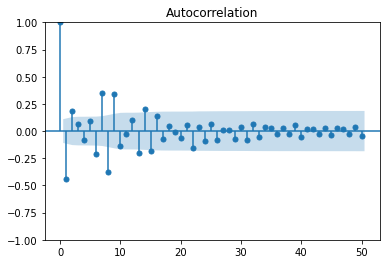

In [44]:
acf_plot = plot_acf(tickrdf.First_Difference, lags = 50)

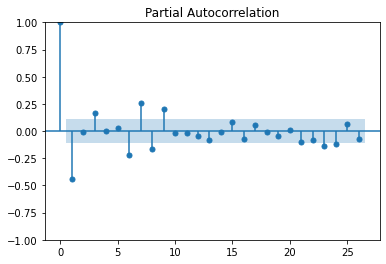

In [45]:
pacf_plot = plot_pacf(tickrdf.First_Difference)

#### From Partial Autocorrelation Curve, we can infer that the Auto Regression model can be run at 1, 3, 6, 7, 8, 9, 23

## Splitting dataset for training and testing the model(s)

In [46]:
print(tickrdf.shape)
train=tickrdf.iloc[:-30]
test=tickrdf.iloc[-30:]
print(train.shape,test.shape)
print(test.iloc[0],test.iloc[-1])

(321, 2)
(291, 2) (30, 2)
Close               156.863144
First_Difference     10.437515
Name: 2020-02-28 00:00:00-05:00, dtype: float64 Close               159.893707
First_Difference      0.000000
Name: 2020-04-09 00:00:00-04:00, dtype: float64


## ARIMA Modeling

In [47]:
import warnings
warnings.filterwarnings("ignore")


model=sm.tsa.arima.ARIMA(train['First_Difference'],order=(1,1,7))
model_fit=model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       First_Difference   No. Observations:                  291
Model:                 ARIMA(1, 1, 7)   Log Likelihood                -589.348
Date:                Sun, 08 Oct 2023   AIC                           1196.697
Time:                        16:40:24   BIC                           1229.726
Sample:                             0   HQIC                          1209.930
                                - 291                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6559      0.250     -2.624      0.009      -1.146      -0.166
ma.L1         -0.3743      1.377     -0.272      0.786      -3.073       2.324
ma.L2         -0.6494      0.789     -0.823      0.411      -2.196       0.898
ma.L3          0.1645      0.070      2.347      0.019       0.027       0.302
ma.L4         -0.0843      0.215     -0.392      0.695      -0.505       0.337
ma.L5         -0.0895      0.121     -0.741      0.459      -0.326       0.147
ma.L6         -0.1066      0.084     -1.263      0.207      -0.272       0.059
ma.L7          0.1397      0.193      0.723      0.470      -0.239       0.519
sigma2         3.3391      4.444      0.751      0.452      -5.370      12.049
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               327.20
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.41   Skew:                            -1.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
start=len(train)
end=len(train)+len(test)-1

<AxesSubplot:xlabel='Date'>

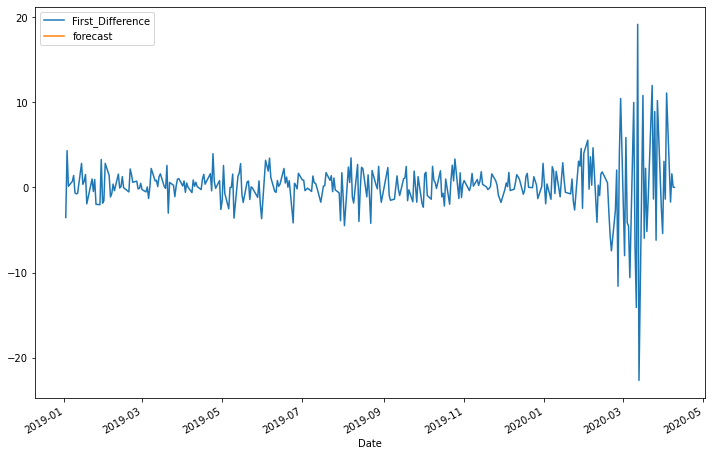

In [49]:
tickrdf['forecast']=model_fit.predict(start = start, end = end)
tickrdf[['First_Difference','forecast']].plot(figsize=(12,8))

## SARIMA Modeling

In [50]:
model_S = SARIMAX(tickrdf['First_Difference'],order=(2, 1, 0),seasonal_order=(1,1,1,30))
result_S = model_S.fit()
result_S.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     First_Difference   No. Observations:                  321
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 30)   Log Likelihood                -786.837
Date:                              Sun, 08 Oct 2023   AIC                           1583.673
Time:                                      16:40:25   BIC                           1602.023
Sample:                                           0   HQIC                          1591.025
                                              - 321                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0484      0.029    -36.071      0.000      -1.105      -0.991
ar.L2         -0.5069      0.028    -18.000      0.000      -0.562      -0.452
ar.S.L30      -0.0901      0.193     -0.466      0.641      -0.469       0.289
ma.S.L30      -0.6082      0.194     -3.141      0.002      -0.988      -0.229
sigma2        12.4859      0.604     20.677      0.000      11.302      13.669
===================================================================================
Ljung-Box (L1) (Q):                   3.47   Jarque-Bera (JB):               380.84
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               6.02   Skew:                             0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='Date'>

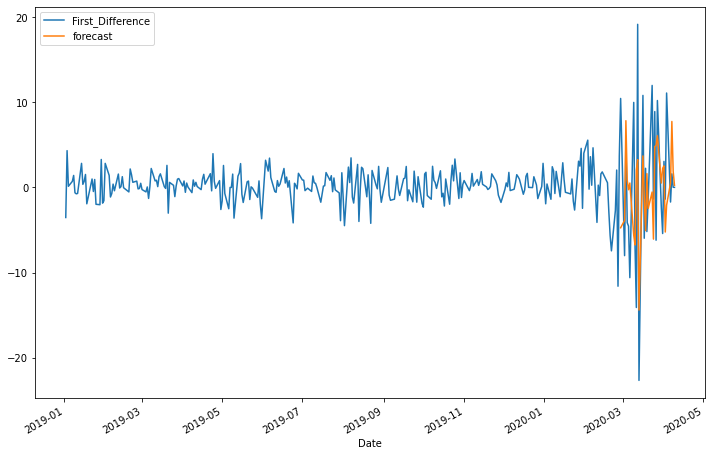

In [54]:
tickrdf['forecast']=result_S.predict(start= start, end =end)
tickrdf[['First_Difference','forecast']].plot(figsize=(12,8))

### Since, we can see that there's no prediction for test dataset in case of ARIMA and there's a prediction in the case of SARIMA;

### Hence, we can conclude that our dataset is seasonal in nature.